In [139]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import statsmodels.api as sm

from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

# I want to read the full contents of each sentiment
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

## Functions

In [140]:
def quick_histogram(series,**kwargs):
    title = kwargs.get('title','Plot of series')
    xlabel = kwargs.get('xlabel','X-axis label')
    ylabel = kwargs.get('ylabel','count')
    plt.hist(series)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

## This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [141]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

#house_df.head(10)

## Data cleaning

In [142]:
# Filling in missing values with 0s, or "NA"
house_df['lotfrontage'].fillna(0,inplace=True)
house_df['masvnrtype'].fillna("NA",inplace=True)
house_df['masvnrarea'].fillna(0.0,inplace=True)
house_df['bsmtqual'].fillna("NA",inplace=True) 
house_df['bsmtcond'].fillna("NA",inplace=True) 
house_df['bsmtfintype1'].fillna("NA",inplace=True) 
house_df['bsmtexposure'].fillna("NA",inplace=True) 
house_df['bsmtfintype2'].fillna("NA",inplace=True) 
house_df['fireplacequ'].fillna("NA",inplace=True)
house_df['garagetype'].fillna("NA",inplace=True) 
house_df['garageyrblt'].fillna("NA",inplace=True) 
house_df['garagefinish'].fillna("NA",inplace=True) 
house_df['garagequal'].fillna("NA",inplace=True) 
house_df['garagecond'].fillna("NA",inplace=True)

In [143]:
# Dropping poorly populated or irrelevant variables
house_df.drop(columns=['id','alley','electrical','poolqc','fence','miscfeature'],inplace=True)

## Feature engineering / setup training data for the model

In [144]:
house_df['log_lotarea'] = np.log(house_df['lotarea'])

In [145]:
house_df['has_porch'] = ((house_df['openporchsf'] > 0) | (house_df['enclosedporch'] > 0) | (house_df['threessnporch'] > 0) | (house_df['screenporch'] > 0)).map({True: 1, False: 0})
house_df['has_deck'] = (house_df['wooddecksf'] > 0).map({True: 1, False: 0})

In [146]:
# Start with these features of interest. 
vars_of_interest = ['saleprice','log_lotarea','neighborhood','bldgtype','housestyle','yearbuilt',
                    'grlivarea','garagearea','has_deck','has_porch']

house_interest_df = house_df[vars_of_interest]
house_interest_df.head()

,saleprice,log_lotarea,neighborhood,bldgtype,housestyle,yearbuilt,grlivarea,garagearea,has_deck,has_porch
0,208500,9.041922,CollgCr,1Fam,2Story,2003,1710,548,0,1
1,181500,9.169518,Veenker,1Fam,1Story,1976,1262,460,1,0
2,223500,9.328123,CollgCr,1Fam,2Story,2001,1786,608,0,1
3,140000,9.164296,Crawfor,1Fam,2Story,1915,1717,642,0,1
4,250000,9.565214,NoRidge,1Fam,2Story,2000,2198,836,1,1


In [147]:
# Append one-hot versions of neighborhoods and house style to the dataframe of interesting variables
house_interest_df = pd.concat([house_interest_df, pd.get_dummies(house_df['neighborhood'],drop_first=True)], axis=1)
house_interest_df = pd.concat([house_interest_df, pd.get_dummies(house_df['housestyle'],drop_first=True)], axis=1)
house_interest_df.head()

,saleprice,log_lotarea,neighborhood,bldgtype,housestyle,yearbuilt,grlivarea,garagearea,has_deck,has_porch,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,1.5Unf,1Story,2.5Fin,2.5Unf,2Story,SFoyer,SLvl
0,208500,9.041922,CollgCr,1Fam,2Story,2003,1710,548,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,181500,9.169518,Veenker,1Fam,1Story,1976,1262,460,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,223500,9.328123,CollgCr,1Fam,2Story,2001,1786,608,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,140000,9.164296,Crawfor,1Fam,2Story,1915,1717,642,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,250000,9.565214,NoRidge,1Fam,2Story,2000,2198,836,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### Of all of the available variables of interest, and one-hot versions of categorical variables, the following list represents the features we previously determined to be significant. Let's train our model.

In [148]:
hidf_features = ['log_lotarea','yearbuilt','grlivarea','garagearea','has_deck','has_porch',
                  'Crawfor','Edwards','Gilbert',
                  'Mitchel','NAmes','NWAmes','NoRidge','NridgHt','Sawyer',
                  'SawyerW','StoneBr','1.5Unf','1Story',
                  'SFoyer','SLvl']

In [149]:
# Y is the target variable
Y = house_interest_df['saleprice'].values.reshape(-1,1)
# X is the feature set. I hope I didn't choose too many features...?
X = house_interest_df[hidf_features]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [[ 2.24092042e+04  7.39106951e+02  7.30409083e+01  3.64481068e+01
   6.75246637e+03  7.86968712e+03  3.29190853e+04 -2.48445059e+04
  -1.78207647e+04 -2.60012927e+04 -1.56290807e+04 -1.97042919e+04
   4.96622948e+04  6.16124510e+04 -2.09355439e+04 -1.86272582e+04
   7.07418090e+04  2.86889813e+04  1.84998849e+04  2.44522166e+04
   1.59788979e+04]]

Intercept: 
 [-1625851.54407805]


## Checking assumptions
### Assumption one: linearity of the model in its coefficients

In [153]:
predictions = lrm.predict(X)
predictions

array([[209945.15113325],
       [174301.50680155],
       [222618.48470905],
       ...,
       [233784.15375277],
       [126138.68314545],
       [142824.97832639]])

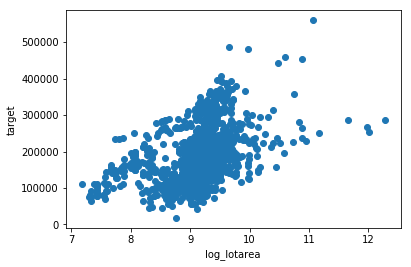

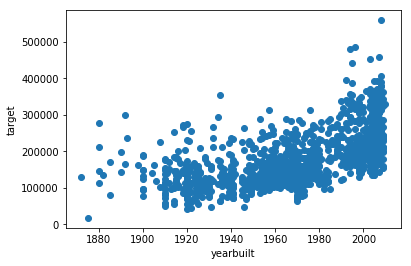

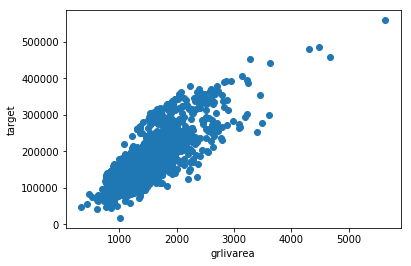

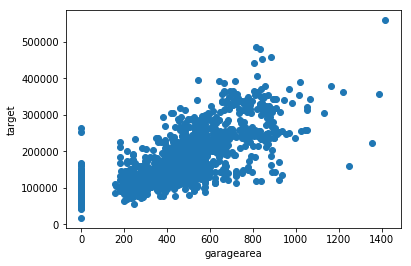

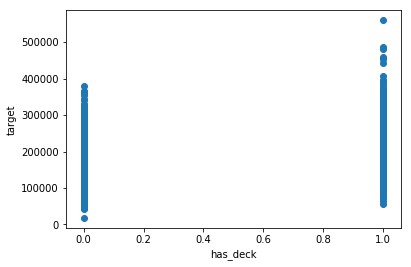

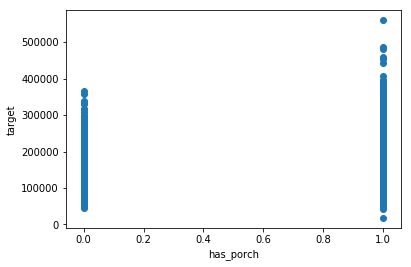

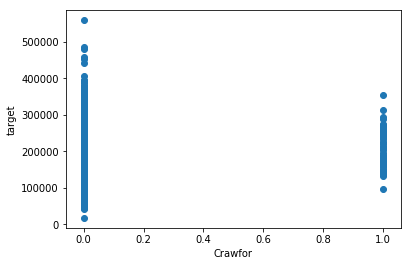

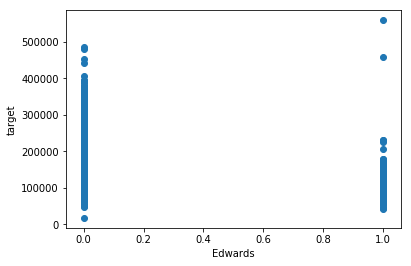

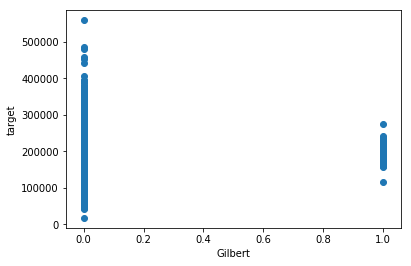

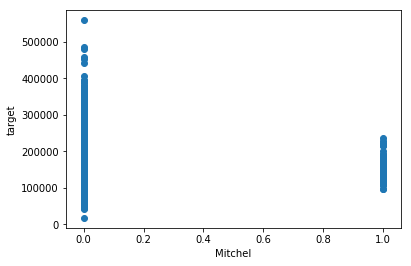

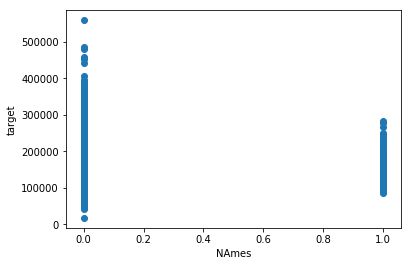

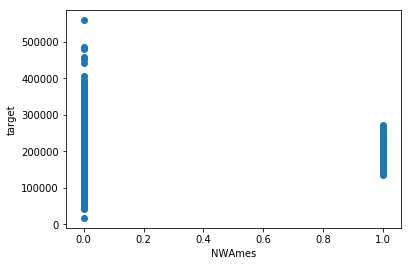

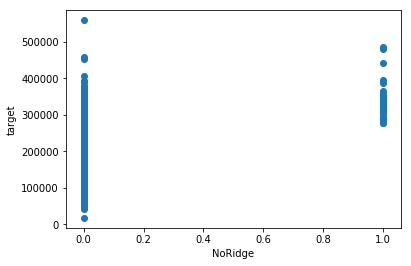

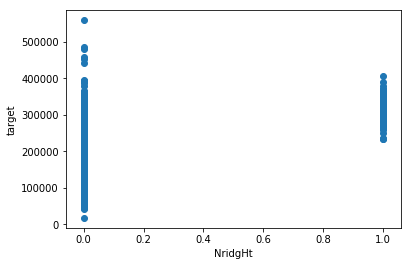

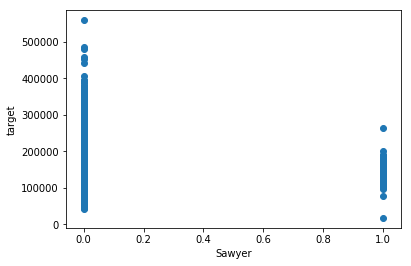

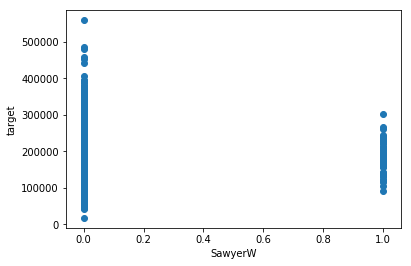

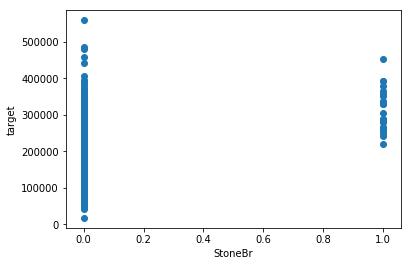

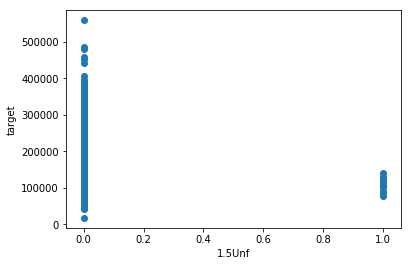

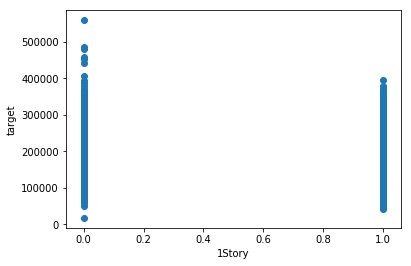

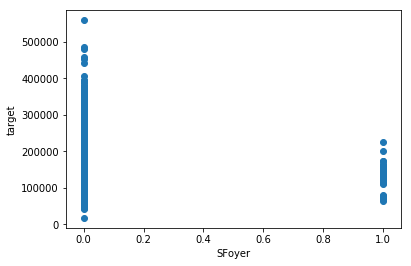

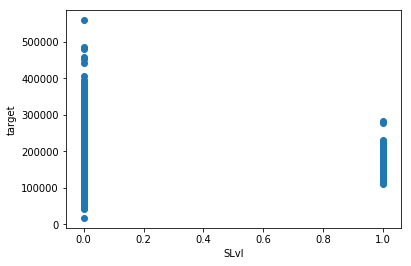

In [155]:
# We plot the estimated Y, and X features
for xfeature in hidf_features:
    plt.scatter(X[xfeature], predictions)
    plt.xlabel(xfeature)
    plt.ylabel("target")
    plt.title('')
    plt.show()

I don't see anything in these plots that would suggest anything besides a linear relationship between the coefficients and the target variable. I think this assumption is good...?

## Assumption two: the error term should be zero on average

Our model has a constant, so this assumption is good.

`-1625851.54407805`

## Assumption three: homoscedasticity

In [157]:
errors = Y - predictions
errors.shape

(1460, 1)

In [158]:
flat_errors = np.ndarray.flatten(errors)
flat_errors

array([-1445.15113325,  7198.49319845,   881.51529095, ...,
       32715.84624723, 15986.31685455,  4675.02167361])

In [159]:
flat_predictions = np.ndarray.flatten(predictions)
flat_predictions

array([209945.15113325, 174301.50680155, 222618.48470905, ...,
       233784.15375277, 126138.68314545, 142824.97832639])

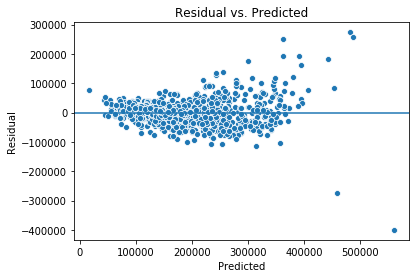

In [160]:
sns.scatterplot(flat_predictions,flat_errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [161]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(flat_predictions, flat_errors)
lev_stats = levene(flat_predictions, flat_errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 577.523 and p value is 1.3e-127
Levene test statistic value is 480.999 and p value is 8.15e-99


__The p-values of both tests are lower than 0.05--the test results reject the null hypothesis of these tests, which means our errors are heteroscedastic.__

I feel like we already reached the optimal number of features--I removed a bunch because they were not significant and hurt our adjusted R-squared value when I generated stats for the model.

Our other option is to try transforming the dependent variable. Maybe a log transformation would help here?

Text(0.5, 0.98, 'Raw and log transformed sale price')

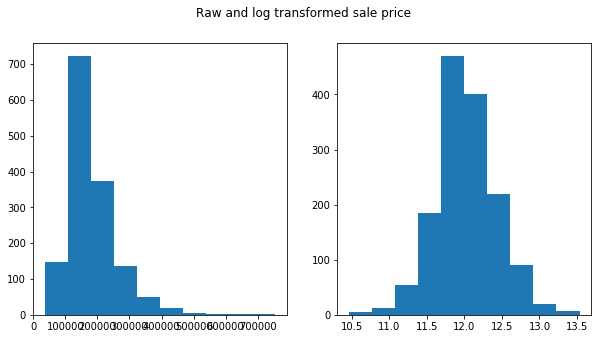

In [169]:
# Tried Box-Cox, but it looked terrible. So let's try a log transformation instead.
#from scipy.stats import boxcox 

fig=plt.subplots(1,2,figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(house_df['saleprice'])

plt.subplot(1,2,2)
plt.hist(np.log(house_df['saleprice']))
plt.suptitle("Raw and log transformed sale price")

In [170]:
# Y is the target variable
Y = np.log(house_interest_df['saleprice']).values.reshape(-1,1)
# X is the feature set. I hope I didn't choose too many features...?
X = house_interest_df[hidf_features]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [[ 1.21321684e-01  4.97712185e-03  3.32994965e-04  2.39082311e-04
   4.80031559e-02  7.41964425e-02  2.48168039e-01 -1.39513331e-01
  -6.85667394e-02 -9.90674790e-02 -2.72230564e-02 -3.36484312e-02
   8.78471693e-02  1.76004242e-01 -6.76689305e-02 -7.59169389e-02
   2.36820900e-01  8.26691400e-02  5.12356183e-02  6.63867929e-02
   7.42781350e-02]]

Intercept: 
 [0.38907543]


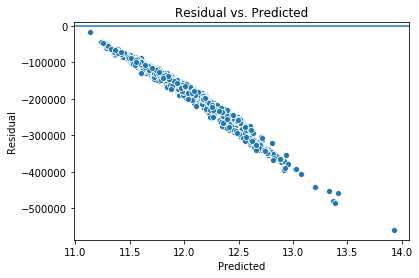

In [171]:
errors = Y - predictions
flat_errors = np.ndarray.flatten(errors)
predictions = lrm.predict(X)
flat_predictions = np.ndarray.flatten(predictions)

sns.scatterplot(flat_predictions,flat_errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [172]:
bart_stats = bartlett(flat_predictions, flat_errors)
lev_stats = levene(flat_predictions, flat_errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 33533.4 and p value is 0
Levene test statistic value is 2035.52 and p value is 0


Okay, still no good. Are outliers of the dependent variable killing us?

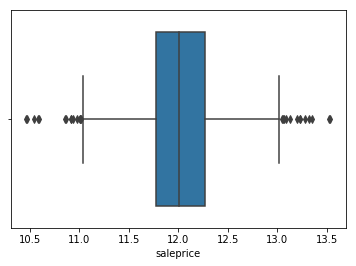

In [175]:
sns.boxplot(np.log(house_df['saleprice']),data=house_df)

In [187]:
from scipy.stats.mstats import winsorize
Y_winz = winsorize(np.log(house_df['saleprice']),(.02,.02))

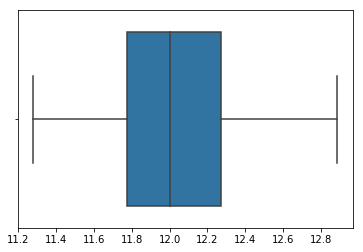

In [188]:
sns.boxplot(Y_winz)

In [194]:
# Y is the target variable
Y = Y_winz.reshape(-1,1)
# X is the feature set. I hope I didn't choose too many features...?
X = house_interest_df[hidf_features]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [[ 1.24751774e-01  4.81670522e-03  2.97915258e-04  2.16384105e-04
   4.47175471e-02  7.16905373e-02  2.40029027e-01 -1.51187859e-01
  -7.11582141e-02 -1.13042914e-01 -4.69662351e-02 -3.49376361e-02
   6.97337001e-02  1.64282259e-01 -8.69597814e-02 -7.76879658e-02
   2.09443392e-01  4.37252629e-02  4.76443700e-02  4.65148600e-02
   6.77751289e-02]]

Intercept: 
 [0.75369746]


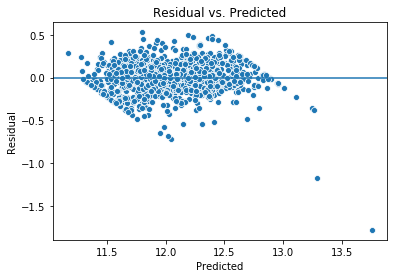

In [195]:
errors = Y - predictions
flat_errors = np.ndarray.flatten(errors)
predictions = lrm.predict(X)
flat_predictions = np.ndarray.flatten(predictions)

sns.scatterplot(flat_predictions,flat_errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [196]:
bart_stats = bartlett(flat_predictions, flat_errors)
lev_stats = levene(flat_predictions, flat_errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 740.09 and p value is 5.73e-163
Levene test statistic value is 725.061 and p value is 7.93e-143


# Okay, stuck now.

Incomplete thoughts below, please ignore. :)

In [127]:
# Try feaure selection again, using PCA this time?
#X = StandardScaler().fit_transform(house_df)
X = StandardScaler().fit_transform(house_interest_df[hidf_features])

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[ 1.00068540e+00  2.19517188e-02  3.94847891e-01  3.22266206e-01
   9.64668114e-02  1.05885889e-01  6.30686206e-02  6.03404424e-04
   7.82237730e-02  5.16287182e-02  6.20164216e-02  1.09342572e-01
   1.23112752e-01  4.86861118e-02  4.48041596e-02  2.68992883e-02
  -1.42227231e-02 -5.15338241e-02  6.31589853e-02 -1.03700805e-01
   3.82246782e-02]
 [ 2.19517188e-02  1.00068540e+00  1.99146115e-01  4.79282095e-01
   3.05504105e-01  1.34478068e-01 -1.87395146e-01 -1.37485659e-01
   2.13915624e-01  6.47732386e-02 -1.59465279e-01  3.31695237e-02
   1.36174841e-01  2.69082369e-01 -5.81427634e-02  1.17608198e-01
   1.19043372e-01 -1.22935456e-01  1.23339562e-01  3.25126708e-02
   2.37294373e-02]
 [ 3.94847891e-01  1.99146115e-01  1.00068540e+00  4.69318929e-01
   1.97533527e-01  2.88708734e-01  1.00081837e-01 -9.06167844e-02
   5.73415302e-02 -7.85464438e-02 -1.66810974e-01  9.27893342e-02
   3.21669834e-01  1.80015401e-01 -1.32196733e-01  3.10995930e-02
   9.14275825e-02 

In [128]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[ 0.25816065  0.37115534  0.46270641  0.45747418  0.26915899  0.26456908
 -0.03034653 -0.13185512  0.11263961 -0.01388168 -0.1803117   0.06606292
  0.22817318  0.23887314 -0.10302723  0.05658382  0.09375607 -0.10142007
 -0.10894893 -0.08786663 -0.01017577]
Eigenvalue 1: 2.6924904811871233
----------------------------------------
Eigenvector 2: 
[ 0.23838693  0.15525248 -0.65849511  0.15386273  0.04302376  0.03102466
  0.09145467  0.05564361 -0.09614708  0.01215205  0.1000489   0.06023815
  0.08071966  0.06870101  0.04004546  0.01365267  0.07473212 -0.10768273
 -0.53954323 -0.22797509 -0.22625025]
Eigenvalue 2: 0.21611277074406657
----------------------------------------
Eigenvector 3: 
[ 0.35607482  0.48611495  0.06421069 -0.47166883 -0.0925668  -0.05948145
 -0.08451832 -0.19580372 -0.33578281 -0.17717743 -0.21879121 -0.1873597
 -0.15701656 -0.13748678 -0.17736593 -0.19823552 -0.08291422  0.00206529
 -0.05749391  0.02463474  0.02235915]
Eigenvalue 3: 0.2994689453359862


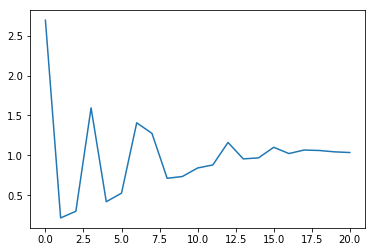

[2.69249048 0.21611277 0.29946895 1.59448825 0.41907329 0.52634184
 1.4074408  1.27527606 0.7122978  0.73510878 0.8414166  0.87981461
 1.16155643 0.95573079 0.96800506 1.10085949 1.02241061 1.06662779
 1.06077628 1.04379312 1.03530363]


In [129]:
# print scree plot
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.1281248  0.07577547 0.06695583 0.06055889 0.0548517 ]


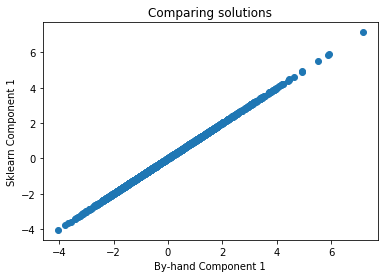

In [130]:
sklearn_pca = PCA(n_components=5)
Y_sklearn = sklearn_pca.fit_transform(X)

P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours – a perfect match.
plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()

In [131]:
# Here are the components we care about
for index, val in enumerate(eig_val_cov):
    if val > 1:
        print("Index {}: value: {}".format(index,val))

Index 0: value: 2.6924904811871233
Index 3: value: 1.5944882485078868
Index 6: value: 1.4074407990895894
Index 7: value: 1.275276056893177
Index 12: value: 1.1615564315192886
Index 15: value: 1.1008594870432966
Index 16: value: 1.022410608823955
Index 17: value: 1.066627788242851
Index 18: value: 1.060776280242776
Index 19: value: 1.0437931157620266
Index 20: value: 1.035303625481646


In [132]:
## Y is the target variable
#Y2 = house_df['saleprice']
## X is the feature set. I hope I didn't choose too many features...?
#X2 = house_df[['grlivarea','NoRidge','Somerst','Timber','2Story']]
#
## We create a LinearRegression model object
## from scikit-learn's linear_model module.
#lrm = linear_model.LinearRegression()
#
## fit method estimates the coefficients using OLS
#lrm.fit(X2, Y2)
#
## Inspect the results.
#print('\nCoefficients: \n', lrm.coef_)
#print('\nIntercept: \n', lrm.intercept_)

In [ ]:
## We need to manually add a constant
## in statsmodels' sm
#X2 = sm.add_constant(X2)
#
#results = sm.OLS(Y2, X2).fit()
#
#results.summary()